In [44]:
import sys
sys.path.append("..")
import functools
import pickle

import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import torch
import pyequion2

import tmcdiff

In [45]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
TK = 298.15
bulk_velocity = 1e0
pipe_diameter = 1e-2
species = ["C", "Ca", "Na", "Cl", "Mg"]
phases = ["Calcite", "Dolomite"]
c_nahco3 = 0.018
c_cacl2 = 0.006
c_nacl = 0.003
c_mgcl2 = 0.003
molal_balance = {'C':c_nahco3,
                 'Ca':c_cacl2,
                 'Na':c_nahco3 + c_nacl,
                 'Cl':2*c_cacl2 + c_nacl + 2*c_mgcl2,
                 'Mg': c_mgcl2}
ngrid = 20
ypmax = 5

In [57]:
solver = tmcdiff.TransportSolver(species)
solver.kreaction = np.array([1e-5, 1e-4])*1e4
solver.set_flow_conditions(TK, bulk_velocity, pipe_diameter)
solver.set_initial_conditions(molal_balance, phases)
solver.build_transport(ngrid, ypmax)
solver.set_initial_guess()

In [58]:
eqsys_front = pyequion2.EquilibriumSystem(species, from_elements=True,
                                           activity_model="DEBYE")
sol, _ = eqsys_front.solve_equilibrium_mixed_balance(TK, molal_balance=molal_balance)
sol.saturation_indexes

{'Aragonite': 1.3784868938022719,
 'Calcite': 1.5222567411945072,
 'Dolomite': 2.882460979559827,
 'Halite': -5.116707444819023,
 'Vaterite': 0.9558252469802078}

In [59]:
solver.load("data/exp2_d")

Text(0, 0.5, 'c [mol/kg H2O]')

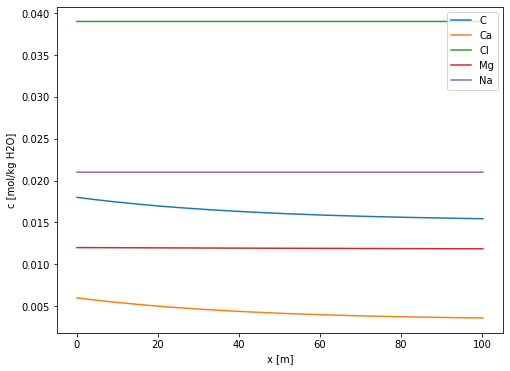

In [60]:
plt.figure(figsize=(8, 6))
for i, el in enumerate(solver.eqsys.solute_elements):
    plt.plot(solver.t*bulk_velocity, solver.x[:, i], label=el)
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("c [mol/kg H2O]")

Text(0, 0.5, 'c [ln (mol/kg H2O)]')

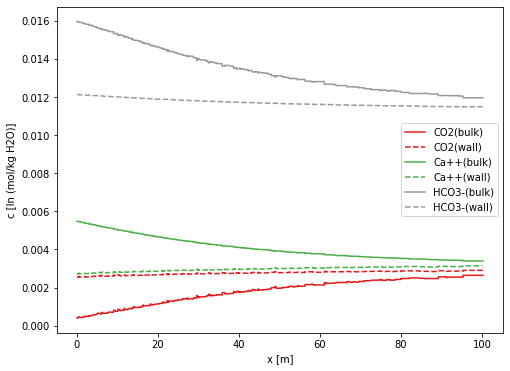

In [61]:
plt.figure(figsize=(8, 6))
cmap = plt.get_cmap("Set1")
for i, el in enumerate(solver.eqsys.solutes):
    if el in ["CO2", "Ca++", "HCO3-"]:
        plt.plot(solver.t*bulk_velocity, np.exp(solver.logc)[:, i, -1], label=el + "(bulk)", color=cmap(i), linestyle='-')
        plt.plot(solver.t*bulk_velocity, np.exp(solver.logc)[:, i, 0], label=el + "(wall)", color=cmap(i), linestyle='--')
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("c [ln (mol/kg H2O)]")

In [62]:
logg = solver.builder.activity_model_func(np.exp(np.moveaxis(solver.logc, -2, -1)), numpy=True)
logg = np.moveaxis(logg, -2, -1)
loga = logg + solver.logc
nu = solver.builder.reduced_reaction_vector.numpy()
logiap = np.einsum("ij, ljm -> lim", nu, loga)
logsatur = logiap - solver.builder.logk_solid[..., None].numpy()

In [74]:
logiap.shae

array([[[-19.409012, -18.82213 , -18.283468, ..., -16.416052,
         -16.40581 , -16.397095],
        [-37.4209  , -36.46752 , -35.55096 , ..., -32.122402,
         -32.103004, -32.086502]],

       [[-19.409012, -18.82213 , -18.28347 , ..., -16.416054,
         -16.405807, -16.397095],
        [-37.4209  , -36.46752 , -35.550964, ..., -32.122402,
         -32.103   , -32.086502]],

       [[-19.409012, -18.82213 , -18.28347 , ..., -16.416054,
         -16.405807, -16.397095],
        [-37.4209  , -36.46752 , -35.550964, ..., -32.122402,
         -32.103   , -32.086502]],

       ...,

       [[-19.51678 , -19.462004, -19.412378, ..., -19.274128,
         -19.273453, -19.272882],
        [-37.76301 , -37.67148 , -37.587997, ..., -37.349808,
         -37.34862 , -37.34762 ]],

       [[-19.51678 , -19.462004, -19.412378, ..., -19.274128,
         -19.273453, -19.272882],
        [-37.76301 , -37.67148 , -37.587997, ..., -37.349808,
         -37.34862 , -37.34762 ]],

       [[-19.5167

In [63]:
c = np.exp(solver.logc)
A = solver.builder.reduced_formula_matrix
cel = np.einsum("ij, ljm -> lim", A, c)
cel_interp = scipy.interpolate.interp1d(solver.t, cel, axis=0)
cinterp = scipy.interpolate.interp1d(solver.t, c, axis=0)

In [64]:
solver.eqsys.solute_elements
dmdt_molm2s = -solver.fluxes[:, 0] #mol/m2 s
dmdt_gm2s = dmdt_molm2s*100.0869 #g/m2 s
dmdt_gms = dmdt_gm2s*(np.pi*pipe_diameter)
dmdt_gmh = dmdt_gms*3600

Text(0, 0.5, 'S.I.')

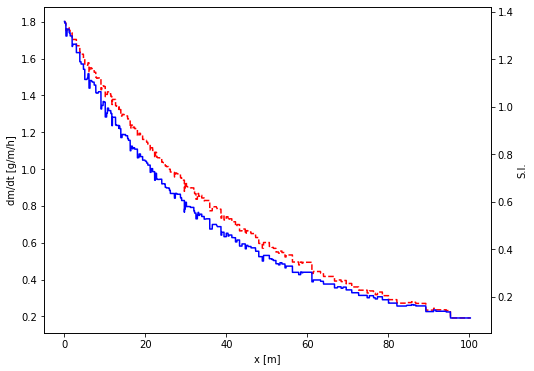

In [65]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
ax1.plot(solver.t[1:], dmdt_gmh, 'r--')
ax2.plot(solver.t*bulk_velocity, logsatur[:, 0, -1]/np.log(10), 'b-')
ax1.set_xlabel("x [m]")
ax1.set_ylabel("dm/dt [g/m/h]")
ax2.set_ylabel("S.I.")

In [72]:
logsatur

array([[[0.11651802, 0.70339966, 1.2420616 , ..., 3.109478  ,
         3.1197205 , 3.1284351 ],
        [1.9302826 , 2.8836594 , 3.8002205 , ..., 7.228779  ,
         7.2481766 , 7.264679  ]],

       [[0.11651802, 0.70339966, 1.2420597 , ..., 3.109476  ,
         3.1197224 , 3.1284351 ],
        [1.9302826 , 2.8836594 , 3.8002167 , ..., 7.228779  ,
         7.2481804 , 7.264679  ]],

       [[0.11651802, 0.70339966, 1.2420597 , ..., 3.109476  ,
         3.1197224 , 3.1284351 ],
        [1.9302826 , 2.8836594 , 3.8002167 , ..., 7.228779  ,
         7.2481804 , 7.264679  ]],

       ...,

       [[0.00874901, 0.06352615, 0.11315155, ..., 0.2514019 ,
         0.2520771 , 0.2526474 ],
        [1.5881729 , 1.6797028 , 1.7631836 , ..., 2.0013733 ,
         2.0025597 , 2.003563  ]],

       [[0.00874901, 0.06352615, 0.11315155, ..., 0.2514019 ,
         0.2520771 , 0.2526474 ],
        [1.5881729 , 1.6797028 , 1.7631836 , ..., 2.0013733 ,
         2.0025597 , 2.003563  ]],

       [[0.008749

Text(0, 0.5, 'S.I.')

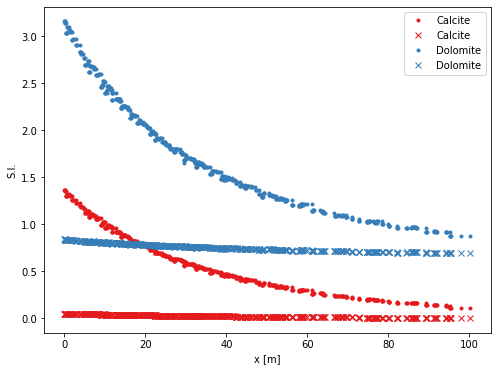

In [66]:
plt.figure(figsize=(8, 6))
for i, phase in enumerate(solver.builder.phases):
    plt.plot(solver.t*bulk_velocity, logsatur[:, i, -1]/np.log(10), label=phase, linestyle=' ',
             marker='.', color=cmap(i))
    plt.plot(solver.t*bulk_velocity, logsatur[:, i, 0]/np.log(10), label=phase, linestyle=' ',
             marker='x', color=cmap(i))
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("S.I.")

In [67]:
solver.eqsys.solute_elements
dmdt_molm2s = -solver.fluxes[:, 0] #mol/m2 s
dmdt_kgm2s = dmdt_molm2s*100.0869 #g/m2 s
dmdt_gms = dmdt_molm2s/(np.pi*pipe_diameter)
dmdt_gmh = dmdt_gms*3600

In [68]:
dmdt_molm2s = solver.builder.reaction_function(torch.tensor(logsatur[:, :, 0]).T).T.numpy() #mol/m2s
dmdt_gm2s = dmdt_molm2s*np.array([100.0869, 184.4008]) #g/m2 s
dmdt_gms = dmdt_gm2s*(np.pi*pipe_diameter)
dmdt_gmh = dmdt_gms*3600

In [69]:
dmdt_molm2s

array([[4.0701161e-05, 4.7338552e-05],
       [4.0701161e-05, 4.7338552e-05],
       [4.0701161e-05, 4.7338552e-05],
       ...,
       [2.8941879e-06, 3.1295152e-05],
       [2.8941879e-06, 3.1295152e-05],
       [2.8941879e-06, 3.1295152e-05]], dtype=float32)

Text(0, 0.5, 'dm/dt [g/m/h]')

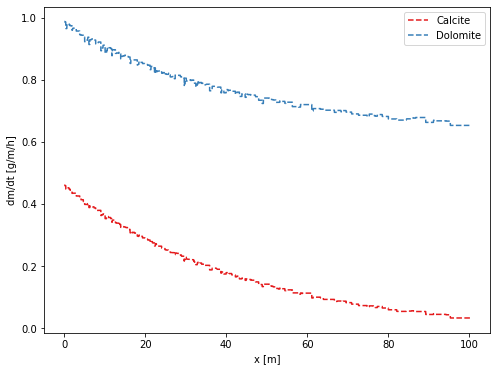

In [70]:
plt.figure(figsize=(8, 6))
for i, phase in enumerate(solver.builder.phases):
    plt.plot(solver.t*bulk_velocity, dmdt_gmh[:, i], label=phase, linestyle='--',
             color=cmap(i))
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("dm/dt [g/m/h]")

Text(0, 0.5, 'c [mol/kg H2O]')

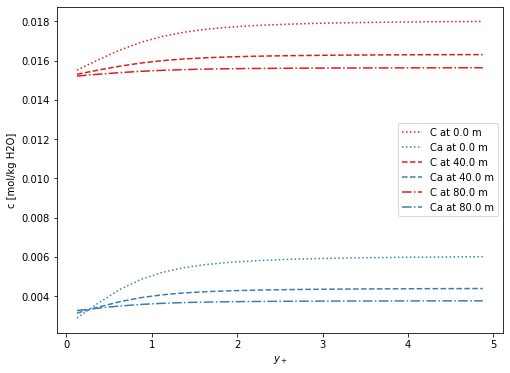

In [71]:
plt.figure(figsize=(8, 6))
t = 40.0
linestyles = [':', '--', '-.']
cmap = plt.get_cmap("Set1")
for j, t in enumerate([0.0, 40.0, 80.0]):
    for i, el in enumerate(solver.eqsys.solute_elements + ['e']):
        if el in ['C', 'Ca']:
            plt.plot(solver.builder.ygrid, cel_interp(t)[i, :],
                     label=f"{el} at {t*bulk_velocity} m",
                     color = cmap(i),
                     linestyle=linestyles[j])
plt.legend()
plt.xlabel(r"$y_+$")
plt.ylabel(r"c [mol/kg H2O]")

Text(0, 0.5, 'c [mol/kg H2O]')

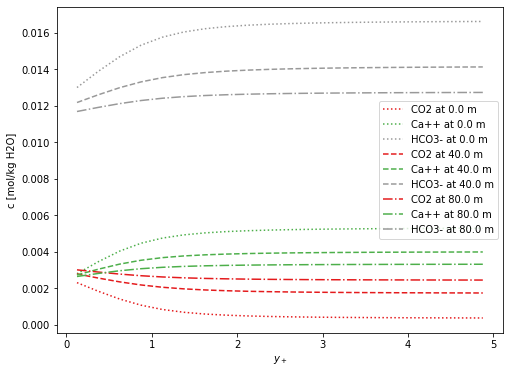

In [150]:
plt.figure(figsize=(8, 6))
t = 40.0
linestyles = [':', '--', '-.']
cmap = plt.get_cmap("Set1")
for j, t in enumerate([0.0, 40.0, 80.0]):
    for i, el in enumerate(solver.eqsys.solutes):
        if el in ["CO2", "Ca++", "HCO3-"]:
            plt.plot(solver.builder.ygrid, cinterp(t)[i, :],
                     label=f"{el} at {t*bulk_velocity} m",
                     color = cmap(i),
                     linestyle=linestyles[j])
plt.legend()
plt.xlabel(r"$y_+$")
plt.ylabel(r"c [mol/kg H2O]")

In [7]:
faraday_constant = 96485.3321233100184
converter = faraday_constant*solver.builder.water_density*solver.builder.wall_length()
plt.figure(figsize=(8, 4))
T, Y = np.meshgrid(solver.t, solver.builder.ygrid[:12])
c_charge = cel[:, -1, :12]
plot = plt.pcolormesh(T, Y, c_charge.transpose(), cmap='Greys', shading='gouraud')
plt.xlabel("x [m]")
plt.ylabel(r"$y_+$")
plt.colorbar(plot)

AttributeError: 'TransportSolver' object has no attribute 't'

<Figure size 576x288 with 0 Axes>

In [34]:
solver.builder.wall_length()

1.4656541470890906e-05